In [2]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pylab  as plt
import scipy
import seaborn as sb

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor
from shapely.geometry import Point, Polygon, shape



In [3]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [4]:
##Update this, its probably not where your DB is
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v5.db')

In [5]:
    cur = con.cursor()

    df = pd.read_sql('''
    select calls_for_service.analysis_neighborhoods as neighborhood
, calls_for_service.call_number
, calls_for_service.incident_number
, floating_catchment_output.[index]
, floating_catchment_output.zone_idx
, floating_catchment_output.accessibility_score
, floating_catchment_output.scenario_name
, calls_for_service.on_scene_dttm
, calls_for_service.response_dttm  
, fire_stations.facility_id
, fire_stations.latitude
, fire_stations.longitude
from floating_catchment_output
inner join zone_idx_to_incident on 
zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx
inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number
left join Truck_Engine_Fire_Station as tfs on tfs.unit = calls_for_service.unit_id
left join fire_stations on fire_stations.facility_id = tfs.facility_id
where calls_for_service.unit_type in ('TRUCK', 'ENGINE')
and scenario_name = 'baseline';''',con = con) 

In [6]:
#do some date math
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds) 
df['day_of_week'] = df['on_scene_dttm'].dt.dayofweek
df['isDayTime'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)

df = df[df['isDayTime'].notna()]
df = df[df['day_of_week'].notna()]
df = df[df['facility_id'].notna()]

In [8]:
df_filtered = df[(df.minutes > 10) & (df.minutes < 40)]

C:\Users\judey\miniconda3\envs\jyEDA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


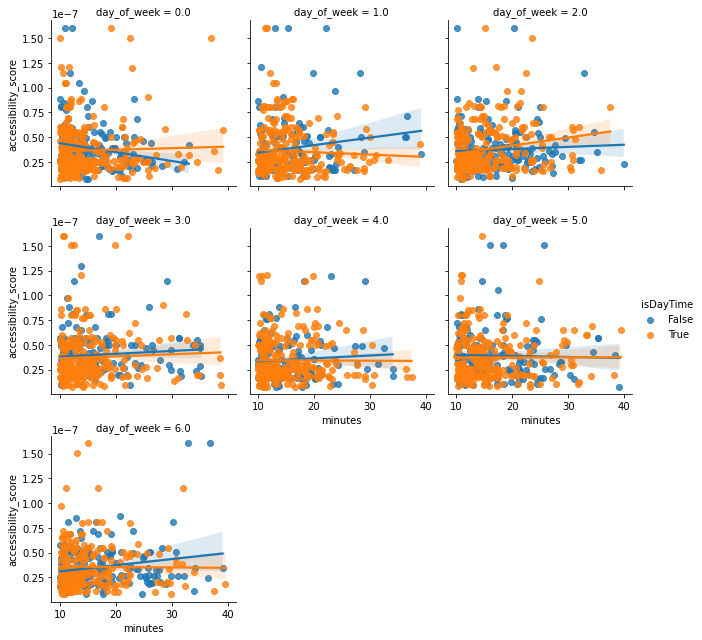

In [9]:
lm = sb.lmplot( "minutes", "accessibility_score", df_filtered, fit_reg=True,hue="isDayTime",col="day_of_week",col_wrap=3,height=3)



In [10]:
df_filtered = df[(df.minutes < 10)]

C:\Users\judey\miniconda3\envs\jyEDA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


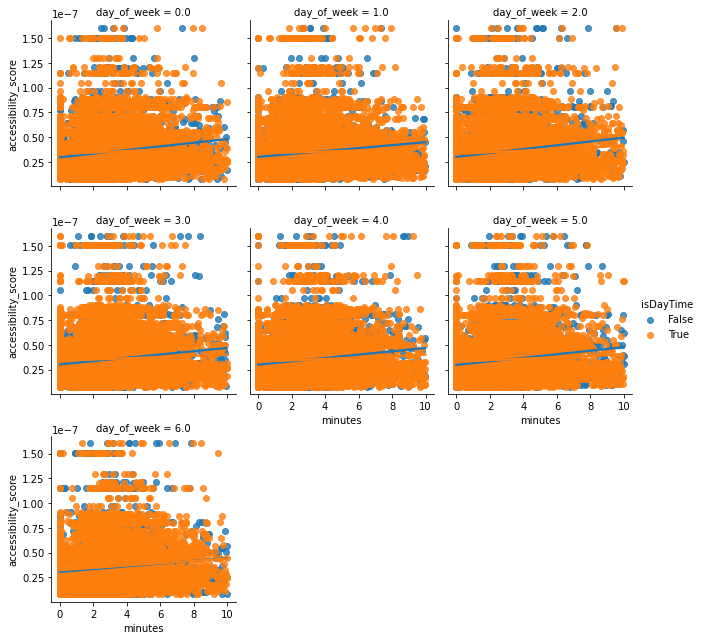

In [11]:
sb.lmplot( "minutes", "accessibility_score", df_filtered, fit_reg=True,hue="isDayTime",col="day_of_week",col_wrap=3,height=3)

In [12]:
df = df[df.minutes < 200]

In [13]:
df["quadrat"] = np.where(
    (df['latitude'] > 37.771258) & (df['longitude'] > -122.441404),
    'NW',
    np.where(
        df['latitude'].between(37.747290, 37.808058) & (df['longitude'] > -122.441404),
        'MW',
    np.where(
        (df['latitude'] < 37.808058) & (df['longitude'] > -122.441404),
        'SW',
    np.where(
        (df['latitude'] > 37.771258) & (df['longitude'] <= -122.441404),
        'NE',
    np.where(
        df['latitude'].between(37.747290, 37.808058) & (df['longitude'] <= -122.441404),
        'ME',
    np.where(
        (df['latitude'] < 37.808058) & (df['longitude'] <= -122.441404),
        'SE', 'EV'
    ),
)))))


In [14]:
df_filtered = df[(df.minutes < 10)]

C:\Users\judey\miniconda3\envs\jyEDA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


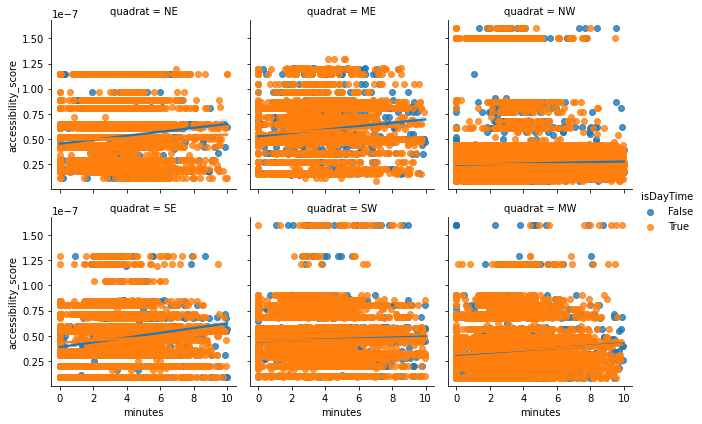

In [15]:
sb.lmplot( "minutes", "accessibility_score", df_filtered, fit_reg=True,hue="isDayTime",col="quadrat",col_wrap=3,height=3)

In [16]:
df_ag = df_filtered.groupby(["facility_id", "day_of_week", "isDayTime", "zone_idx", "quadrat"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
print(len(df_ag))
df_ag.head()

11282


,facility_id,day_of_week,isDayTime,zone_idx,quadrat,accessibility_score,minutes
0,691.0,0.0,False,235,NW,7.686985e-08,3.008333
1,691.0,0.0,False,247,NW,2.453413e-08,2.880000
2,691.0,0.0,False,248,NW,1.674024e-08,3.189189
3,691.0,0.0,False,249,NW,3.204539e-08,3.200000
4,691.0,0.0,False,267,NW,2.512921e-08,3.105385


C:\Users\judey\miniconda3\envs\jyEDA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\judey\miniconda3\envs\jyEDA\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


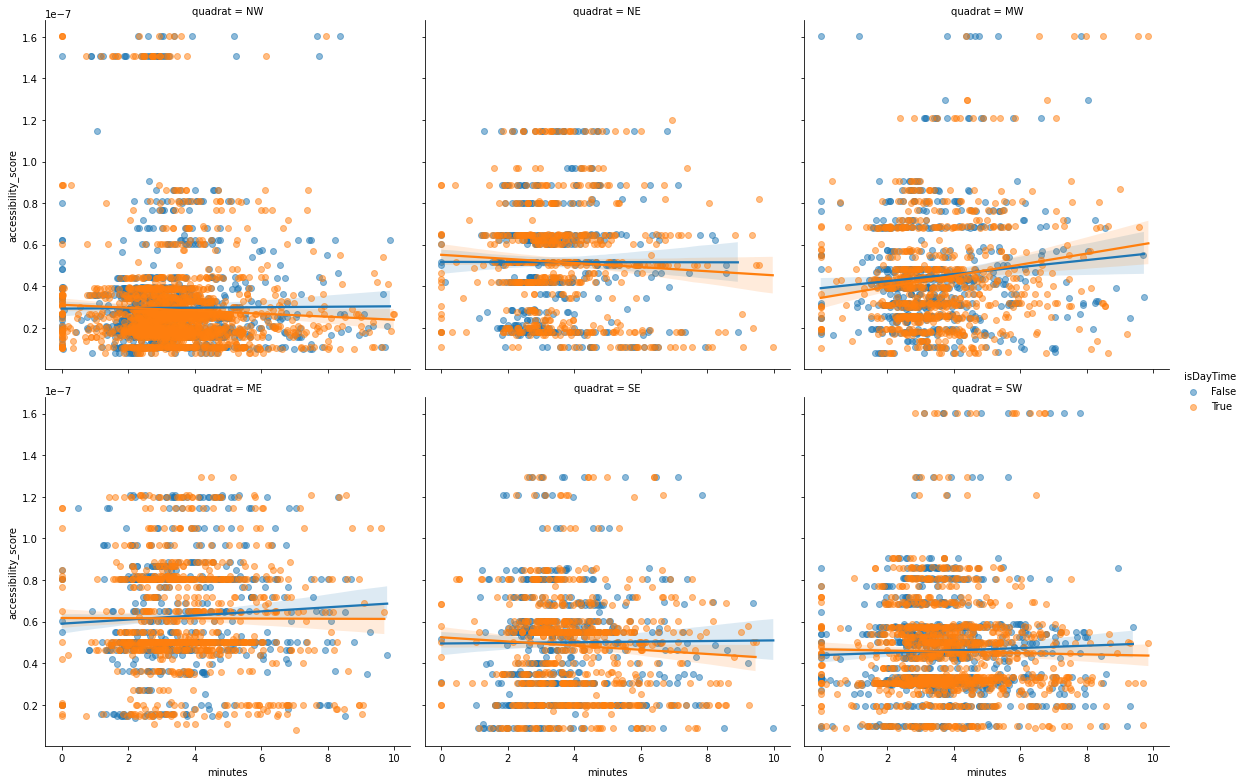

In [34]:
sb.lmplot( "minutes", "accessibility_score", df_ag, fit_reg=True,hue="isDayTime",col="quadrat",col_wrap=3,height=3, scatter_kws={'alpha':0.5}, size=5.5)

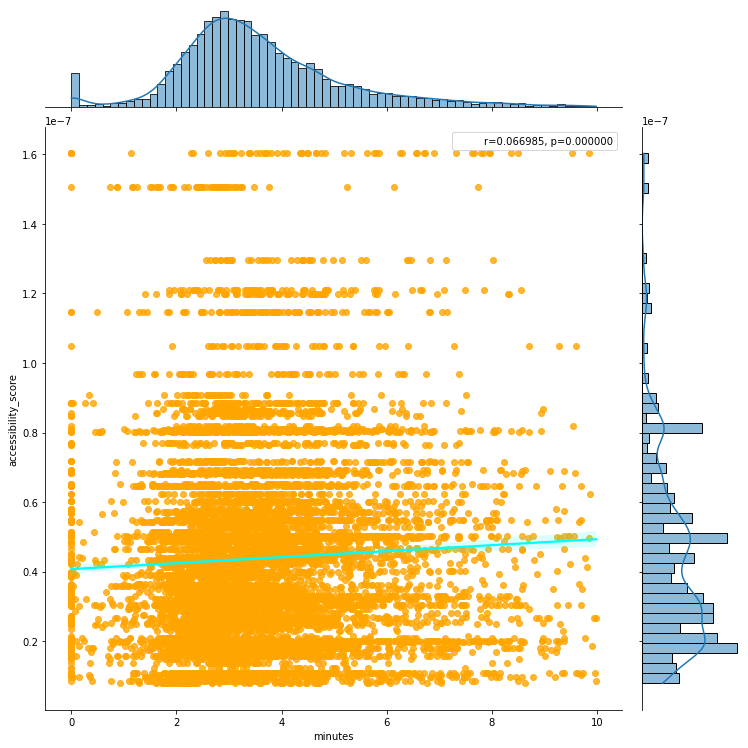

In [42]:
import scipy.stats as stats

g = sb.jointplot(x="minutes", y="accessibility_score", data=df_ag, kind='reg', height=10.5, joint_kws={'color':'orange'}, line_kws={'color':'cyan'})
r, p = stats.spearmanr(df_ag["minutes"], df_ag["accessibility_score"])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
